p# Importing libraries

In [39]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import networkx as nx


# SEED = 19 + 14 ## sum of length of our full names or just use 42
SEED = 19052025

## Defining helper functions

In [40]:
def plot_poisson_dag():
    G = nx.DiGraph()

    labels = {
        'X': 'X (Predictors)',
        'nkill': 'nkill (Observed Counts)',
        'alpha': 'alpha',
        'beta': 'beta',
        'eta': 'eta = alpha + X * beta',
        'nkill_dist': 'Poisson_log(nkill | eta)',
        'nkill_pred': 'nkill_pred'
    }

    G.add_nodes_from(labels)

    G.add_edges_from([
        ('X', 'eta'),
        ('beta', 'eta'),
        ('alpha', 'eta'),
        ('eta', 'nkill_dist'),
        ('nkill_dist', 'nkill'),
        ('eta', 'nkill_pred')
    ])

    pos = {
        'X': (0, 2),
        'alpha': (0, 0),
        'beta': (2, 0),
        'eta': (1, 1),
        'nkill_dist': (3, 1),
        'nkill': (4, 1),
        'nkill_pred': (3, -1),
    }

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color='skyblue', arrowsize=20)

    ax = plt.gca()
    for node, (x, y) in pos.items():
        ax.text(
            x, y + 0.05,
            labels[node],
            ha='center',
            fontsize=9,
            fontweight='bold',
            color='white',
            bbox=dict(facecolor='black', alpha=0.75, boxstyle='round, pad=0.2')
        )

    plt.title('Poisson Regression Model DAG')
    plt.axis('off')
    plt.show()


def plot_negative_binomial_dag():
    G = nx.DiGraph()

    labels = {
        'X': 'X (Predictors)',
        'nkill': 'nkill (Observed Counts)',
        'alpha': 'alpha',
        'beta': 'beta',
        'phi': 'phi',
        'eta': 'eta = alpha + X * beta',
        'nkill_dist': 'NegBinomial_2_log(nkill | eta, phi)',
        'nkill_pred': 'nkill_pred'
    }
    for node in labels:
        G.add_node(node)

    G.add_edges_from([
        ('X', 'eta'),
        ('beta', 'eta'),
        ('alpha', 'eta'),
        ('phi', 'nkill_dist'),
        ('eta', 'nkill_dist'),
        ('nkill_dist', 'nkill'),
        ('phi', 'nkill_pred'),
        ('eta', 'nkill_pred')
    ])

    pos = {
        'X': (0, 2),
        'alpha': (0, 0),
        'beta': (2, 0),
        'eta': (1, 1),
        'phi': (2, -1),
        'nkill_dist': (3, 1),
        'nkill': (4, 1),
        'nkill_pred': (3, -1),
    }

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color='skyblue', arrowsize=20)

    ax = plt.gca()
    for node, (x, y) in pos.items():
        if node == "nkill":
            y = y - 0.1
        else:
            y = y + 0.05
        ax.text(
            x, y,
            labels[node],
            ha='center',
            fontsize=9,
            fontweight='bold',
            color='white',
            bbox=dict(facecolor='black', alpha=0.75, boxstyle='round, pad=0.2')
        )

    plt.title('Negative Binomial Regression Model DAG')
    plt.axis('off')
    plt.show()

## Load & preparing data

In [41]:
# df = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='latin-1')
df = pd.read_csv("Project/Data-Analitics-Project/globalterrorismdb_0718dist.csv", encoding='latin-1')
df.head()

/tmp/ipykernel_94/622743915.py:2: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Project/Data-Analitics-Project/globalterrorismdb_0718dist.csv", encoding='latin-1')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [42]:
selected_columns = ['nkill', 'attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'country_txt', 'nperps']
df = df[selected_columns].dropna()
df = df.sample(n=1000, random_state=SEED)
df.to_csv('data.csv')

## Counting mean and standard deviation

In [43]:
alpha_mean = np.log1p(df['nkill']).mean()
alpha_std = np.log1p(df['nkill']).std()

print(alpha_mean, alpha_std)

0.6556997028950566 0.8329748748676082


In [44]:
np.mean(df['nperps']), np.std(df['nperps'])

(np.float64(-71.158), np.float64(55.56462036224129))

In [45]:
print(df.describe())

             nkill       nperps
count  1000.000000  1000.000000
mean      2.329000   -71.158000
std       7.539071    55.592424
min       0.000000   -99.000000
25%       0.000000   -99.000000
50%       1.000000   -99.000000
75%       2.000000   -99.000000
max     126.000000   500.000000


In [46]:
categorical_cols = ['attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'country_txt']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Standardisation of variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(['nkill'], axis=1))

In [47]:
stan_data = {
    'N': df_encoded.shape[0],
    'K': X_scaled.shape[1],
    'X': X_scaled,
    'nkill': df_encoded['nkill'].astype(int).values
}

## Building & fitting first model

In [48]:
# model_ppc = CmdStanModel(stan_file='code_1.stan')
model_ppc = CmdStanModel(stan_file='Project/Data-Analitics-Project/code_1.stan')

fit = model_ppc.sample(
    data=stan_data,
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=SEED
)

print(fit.summary())

22:35:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:35:20 - cmdstanpy - INFO - CmdStan done processing.



                         Mean      MCSE    StdDev       MAD           5%  \
lp__              1334.460000  0.199747  7.512130  7.368520  1321.570000   
alpha               -0.484845  0.002225  0.081986  0.082146    -0.624363   
beta[1]              0.402948  0.000498  0.019974  0.020449     0.370782   
beta[2]             -0.160577  0.000666  0.033244  0.032956    -0.214763   
beta[3]             -0.252210  0.001001  0.052810  0.053090    -0.339921   
...                       ...       ...       ...       ...          ...   
nkill_pred[996]      0.016250       NaN  0.126451  0.000000     0.000000   
nkill_pred[997]      1.179500  0.017465  1.115840  1.482600     0.000000   
nkill_pred[998]      2.913000  0.027816  1.720510  1.482600     0.000000   
nkill_pred[999]      2.719250  0.027146  1.705770  1.482600     0.000000   
nkill_pred[1000]     0.152000  0.006176  0.391068  0.000000     0.000000   

                          50%          95%  ESS_bulk  ESS_tail     R_hat  
lp__       

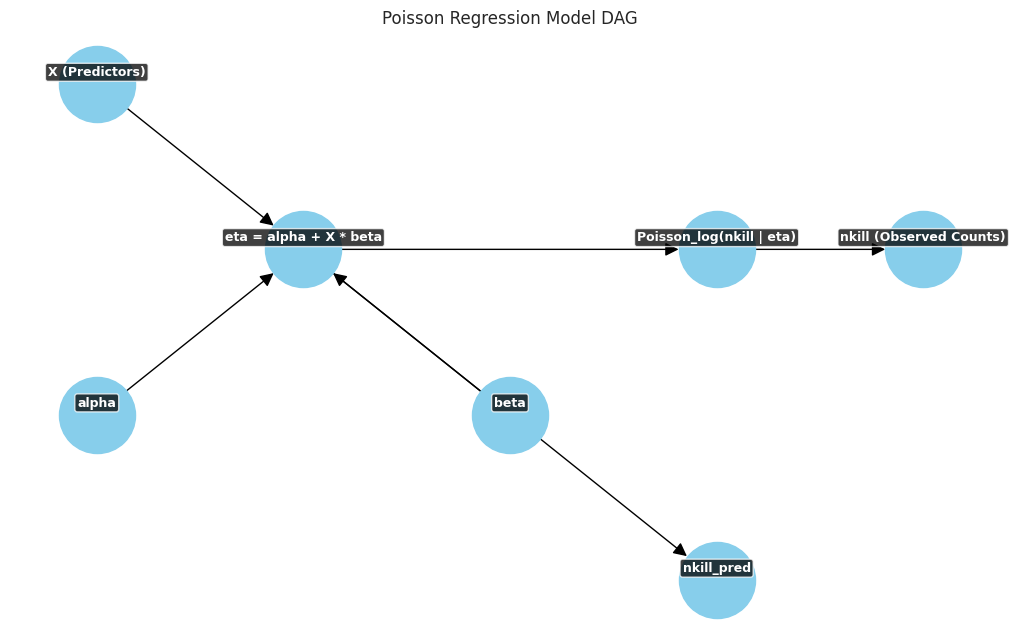

In [49]:
plot_poisson_dag()

## Presenting results

In [50]:
y_pred_poisson = fit.stan_variable('nkill_pred')
y_true_poisson = df_encoded['nkill'].values
y_pred_mean_poisson = np.mean(y_pred_poisson, axis=0)

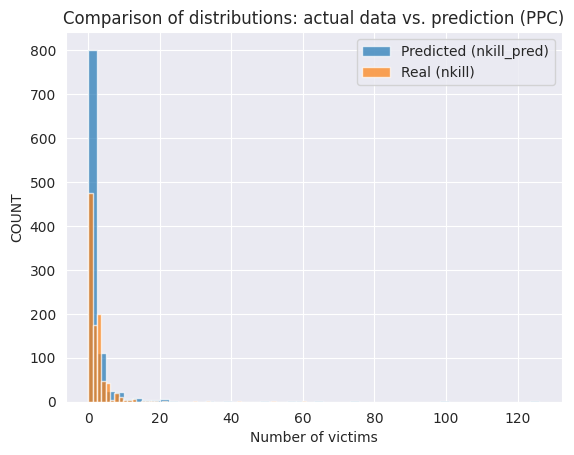

In [51]:
plt.hist(y_true_poisson, bins=50, alpha=0.7, label='Predicted (nkill_pred)')
plt.hist(y_pred_mean_poisson, bins=50, alpha=0.7, label='Real (nkill)')
plt.xlabel('Number of victims')
plt.ylabel('COUNT')
plt.legend()
plt.title('Comparison of distributions: actual data vs. prediction (PPC)')
plt.show()


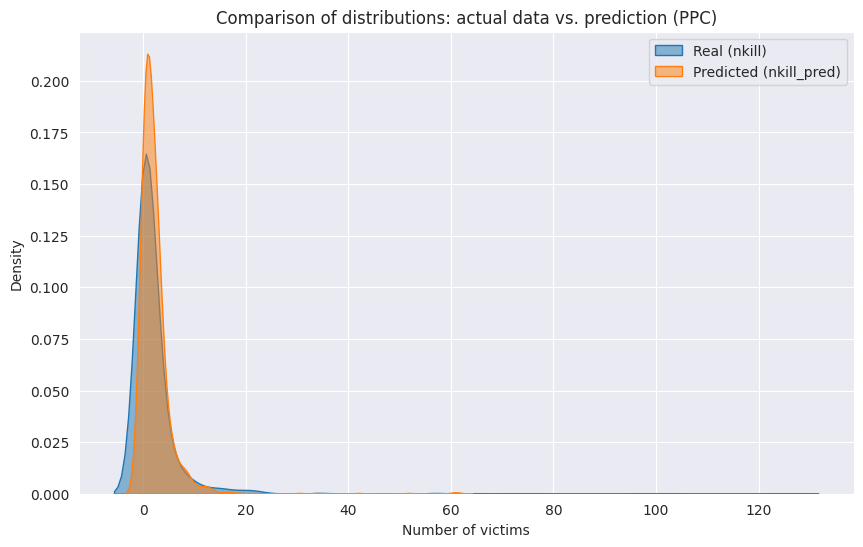

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.kdeplot(y_true_poisson, label='Real (nkill)', fill=True, alpha=0.5)
sns.kdeplot(y_pred_mean_poisson, label='Predicted (nkill_pred)', fill=True, alpha=0.5)
plt.xlabel('Number of victims')
plt.ylabel('Density')
plt.legend()
plt.title('Comparison of distributions: actual data vs. prediction (PPC)')
plt.show()


In [53]:
for n in range(0, 500000):
    true_count = np.sum(y_true_poisson == n)
    pred_count = np.sum(np.round(y_pred_mean_poisson) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")


Number of victims = 0: Real = 488, Predicted = 303
Number of victims = 1: Real = 221, Predicted = 231
Number of victims = 2: Real = 92, Predicted = 139
Number of victims = 3: Real = 52, Predicted = 165
Number of victims = 4: Real = 35, Predicted = 54
Number of victims = 5: Real = 23, Predicted = 23
Number of victims = 6: Real = 11, Predicted = 26
Number of victims = 7: Real = 14, Predicted = 10
Number of victims = 8: Real = 8, Predicted = 12
Number of victims = 9: Real = 9, Predicted = 11
Number of victims = 10: Real = 6, Predicted = 4
Number of victims = 11: Real = 3, Predicted = 2
Number of victims = 12: Real = 4, Predicted = 4
Number of victims = 13: Real = 0, Predicted = 5
Number of victims = 14: Real = 5, Predicted = 0
Number of victims = 15: Real = 4, Predicted = 0
Number of victims = 16: Real = 1, Predicted = 2
Number of victims = 17: Real = 3, Predicted = 1
Number of victims = 18: Real = 1, Predicted = 0
Number of victims = 19: Real = 2, Predicted = 1
Number of victims = 20: Re

## Building & fitting second model

In [54]:
# model_ppc = CmdStanModel(stan_file='code_2.stan')
model_ppc = CmdStanModel(stan_file='Project/Data-Analitics-Project/code_2.stan')

fit = model_ppc.sample(
    data=stan_data,
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=SEED
)

print(fit.summary())

22:35:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:35:43 - cmdstanpy - INFO - CmdStan done processing.
22:35:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomia


                         Mean      MCSE    StdDev       MAD           5%  \
lp__             -1639.150000  0.203177  7.917080  7.679870 -1652.660000   
alpha               -0.296827  0.002028  0.091418  0.090066    -0.448176   
beta[1]              0.427304  0.001081  0.065344  0.064197     0.319960   
beta[2]             -0.041452  0.001125  0.071307  0.068666    -0.158722   
beta[3]             -0.085405  0.002072  0.137463  0.138217    -0.307149   
...                       ...       ...       ...       ...          ...   
nkill_pred[996]      0.085250       NaN  0.347869  0.000000     0.000000   
nkill_pred[997]      1.273250  0.033231  2.111680  0.000000     0.000000   
nkill_pred[998]      2.339750  0.053316  3.344340  1.482600     0.000000   
nkill_pred[999]      2.479500  0.062032  3.869150  1.482600     0.000000   
nkill_pred[1000]     0.541000  0.016962  1.049330  0.000000     0.000000   

                          50%          95%  ESS_bulk  ESS_tail     R_hat  
lp__       

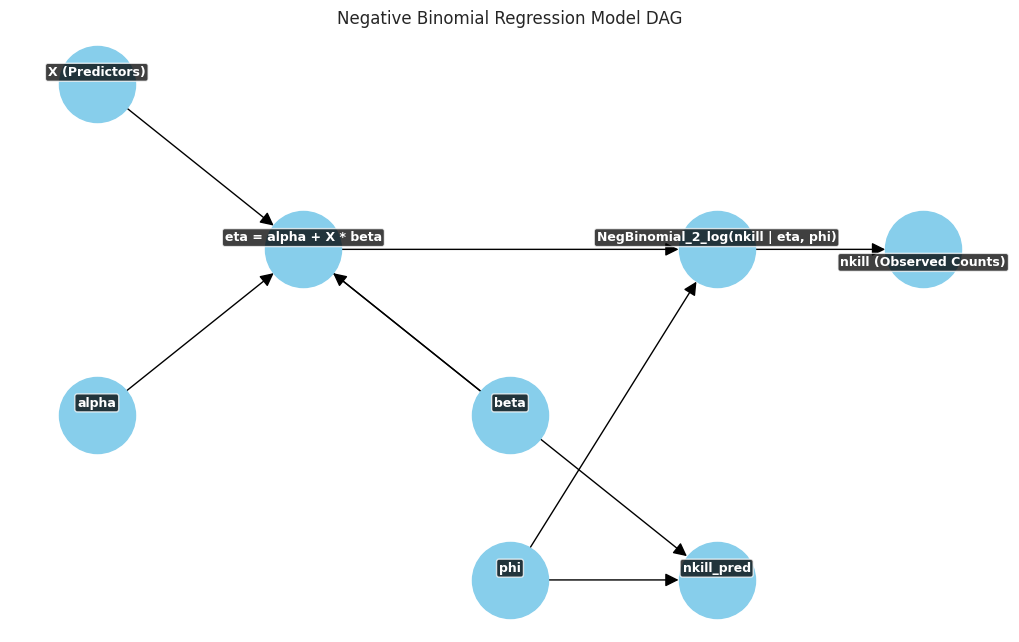

In [55]:
plot_negative_binomial_dag()

## Presenting results for second model

In [56]:
y_pred_binomial = fit.stan_variable('nkill_pred')
y_true_binomial = df_encoded['nkill'].values
y_pred_mean_binomial = np.mean(y_pred_binomial, axis=0)

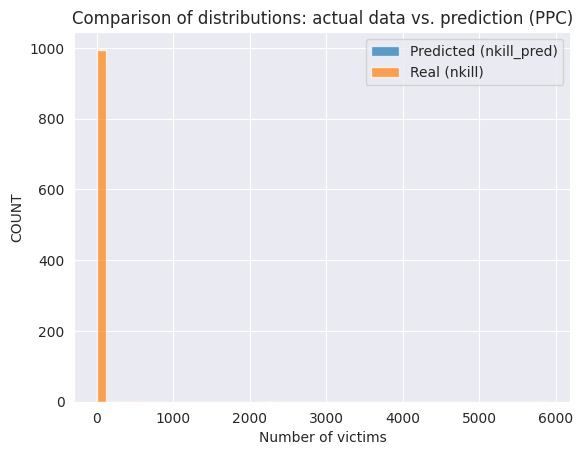

In [57]:
plt.hist(y_true_binomial, bins=50, alpha=0.7, label='Predicted (nkill_pred)')
plt.hist(y_pred_mean_binomial, bins=50, alpha=0.7, label='Real (nkill)')
plt.xlabel('Number of victims')
plt.ylabel('COUNT')
plt.legend()
plt.title('Comparison of distributions: actual data vs. prediction (PPC)')
plt.show()

In [58]:
for n in range(0, 500):
    true_count = np.sum(y_true_binomial == n)
    pred_count = np.sum(np.round(y_pred_mean_binomial) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")


Number of victims = 0: Real = 488, Predicted = 215
Number of victims = 1: Real = 221, Predicted = 237
Number of victims = 2: Real = 92, Predicted = 256
Number of victims = 3: Real = 52, Predicted = 91
Number of victims = 4: Real = 35, Predicted = 48
Number of victims = 5: Real = 23, Predicted = 44
Number of victims = 6: Real = 11, Predicted = 13
Number of victims = 7: Real = 14, Predicted = 14
Number of victims = 8: Real = 8, Predicted = 9
Number of victims = 9: Real = 9, Predicted = 13
Number of victims = 10: Real = 6, Predicted = 19
Number of victims = 11: Real = 3, Predicted = 1
Number of victims = 12: Real = 4, Predicted = 8
Number of victims = 13: Real = 0, Predicted = 5
Number of victims = 14: Real = 5, Predicted = 0
Number of victims = 15: Real = 4, Predicted = 0
Number of victims = 16: Real = 1, Predicted = 1
Number of victims = 17: Real = 3, Predicted = 1
Number of victims = 18: Real = 1, Predicted = 1
Number of victims = 19: Real = 2, Predicted = 2
Number of victims = 20: Rea

## Comparing first and second model with actual data

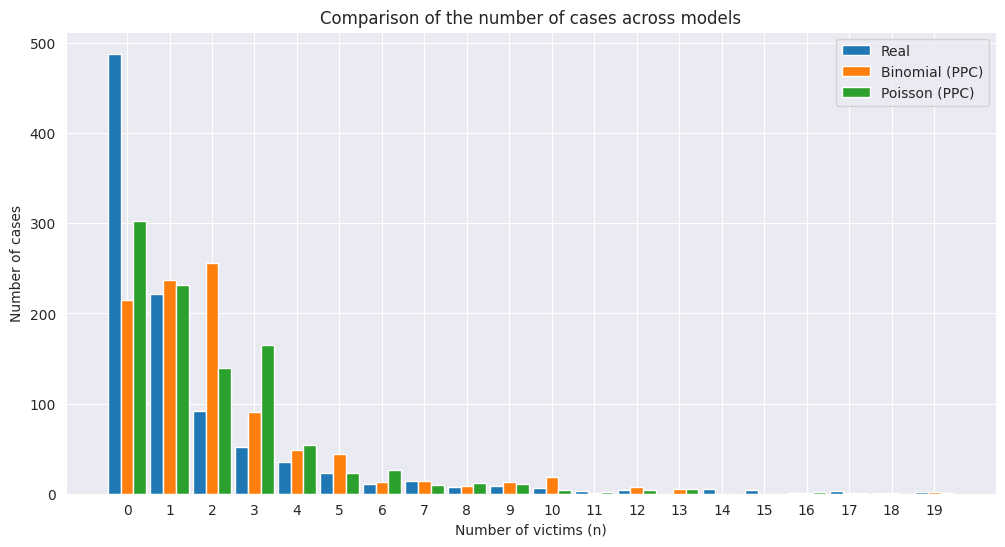

In [59]:
import numpy as np
import matplotlib.pyplot as plt

n_values = np.arange(0, 20)


true_counts = []
binomial_counts = []
poisson_counts = []

for n in n_values:
    true_count = np.sum(y_true_binomial == n)
    binomial_count = np.sum(np.round(y_pred_mean_binomial) == n)
    poisson_count = np.sum(np.round(y_pred_mean_poisson) == n)
    
    true_counts.append(true_count)
    binomial_counts.append(binomial_count)
    poisson_counts.append(poisson_count)


bar_width = 0.3
index = np.arange(len(n_values))

plt.figure(figsize=(12,6))
plt.bar(index - bar_width, true_counts, bar_width, label='Real')
plt.bar(index, binomial_counts, bar_width, label='Binomial (PPC)')
plt.bar(index + bar_width, poisson_counts, bar_width, label='Poisson (PPC)')

plt.xlabel('Number of victims (n)')
plt.ylabel('Number of cases')
plt.xticks(index, n_values)
plt.legend()
plt.title('Comparison of the number of cases across models')
plt.show()


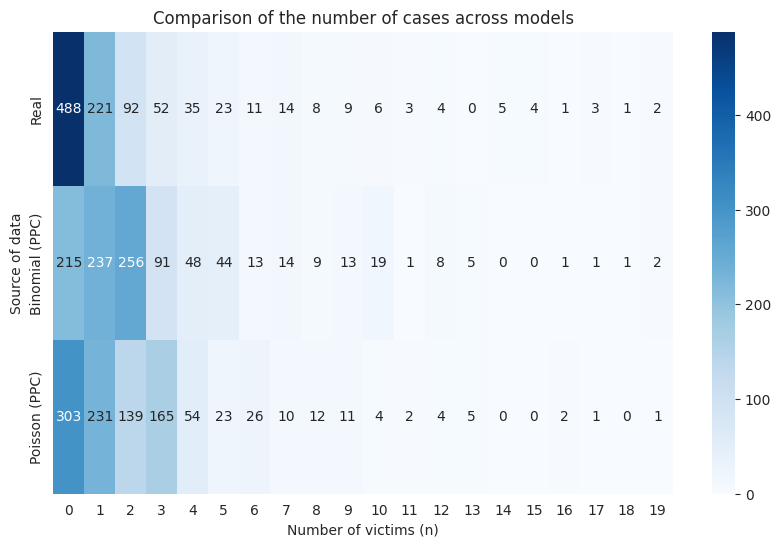

In [60]:
import pandas as pd
import seaborn as sns

df_heatmap = pd.DataFrame({
    'n': n_values,
    'Real': true_counts,
    'Binomial (PPC)': binomial_counts,
    'Poisson (PPC)': poisson_counts
}).set_index('n')

plt.figure(figsize=(10,6))
sns.heatmap(df_heatmap.T, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison of the number of cases across models')
plt.xlabel('Number of victims (n)')
plt.ylabel('Source of data')
plt.show()